In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm 
# plot
# import seaborn as sns
import matplotlib.pyplot as plt 

# Gensim for sentiment analysis
import gensim
from gensim.utils import simple_preprocess

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples
from nltk.stem import WordNetLemmatizer



from collections  import Counter
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

# import tweepy 
# from tweepy import OAuthHandler
# !pip install textblob 
from textblob import TextBlob 
import json

# ! python -m spacy download en_core_web_sm
# ! pip install nlpretext

from nlpretext import Preprocessor
from nlpretext.basic.preprocess import (normalize_whitespace, remove_punct, remove_eol_characters, remove_stopwords, lower_text, fix_bad_unicode, replace_urls)
from nlpretext.social.preprocess import remove_mentions, remove_hashtag, remove_emoji, convert_emoji_to_text


In [16]:
f = open("global_InternationalNursesDay.json", "r")
df = json.loads(f.read())

In [3]:
print(df['tweets'][0]['user']['name'], 'user name')
print(df['tweets'][0]['user']['id'], 'user id')
print(df['tweets'][0]['entities']['hashtags'], 'hashtags')
print(df['tweets'][0]['entities']['user_mentions'], 'user metions')
print(df['tweets'][1]['entities']['urls'], 'urls')
print(df['tweets'][0]['id_str'], 'tweet_id')
str.encode(df['tweets'][0]['text'].replace("'b'", " "), encoding='raw_unicode_escape').decode('unicode_escape').encode('raw_unicode_escape').decode('utf-8')

caryn cooper user name
83360006 user id
[] hashtags
[{'screen_name': 'NightForNurses', 'name': 'Night', 'id': 1320438629647458305, 'id_str': '1320438629647458305', 'indices': [3, 18]}] user metions
[{'url': 'https://t.co/PiHHZv3taC', 'expanded_url': 'https://yt.be/Hn9kF', 'display_url': 'yt.be/Hn9kF', 'indices': [110, 133]}] urls
1392932511018278917 tweet_id


"RT @NightForNurses: If you're an NHS nurse and struggle with your mental health, we are here to help.\\U0001f308\n\nContact us today at https://t.co/qK\\u2026"

In [18]:
data = []
ctr =0 
hashtags = {}
for i in df['tweets']:
    for k in i['entities']['hashtags']:
        if hashtags.get(k['text']):
            hashtags[k['text']]+=1
        else:
            hashtags[k['text']]=1
    try:
        temp = [
            i['id_str'],
            i['text'].replace("'b'", " "),
            i['user']['name'],
            i['user']['id'], 
            ', '.join(sorted([k['text'] for k in i['entities']['hashtags']])), 
            ', '.join([k['id_str']  for k in i['entities']['user_mentions']]), 
            ', '.join([k['url'] for k in i['entities']['urls']]),
        ]
        data.append(temp)
    except Exception as e:
        print(e)
        ctr+=1

In [38]:
# ' मैं'.replace("'b'", " ")
# str.encode(, encoding='raw_unicode_escape').decode('unicode_escape').encode('raw_unicode_escape').decode('utf-8')
hashtags

In [20]:
df = pd.DataFrame(data, columns = ['tweet_id', 'text', 'user_name', 'user_id', 'hashtags', 'user_mentions', 'urls'])

In [21]:
df.head()

tweet_id                                               text  \
0  1392932511018278917  RT @NightForNurses: If you're an NHS nurse and...   
1  1392932510196248578  RT @YouTube: For #InternationalNursesDay, watc...   
2  1392932097493327872  RT @RahulGandhi: My wishes to those who are nu...   
3  1392932014920241153  RT @NHSMillion: Please RT if you agree nurses ...   
4  1392931850482487298  RT @Lindsaclarke: #FlorenceNightingale broke b...   

        user_name              user_id                hashtags  \
0    caryn cooper             83360006                           
1        Kamaljit            368099691  InternationalNursesDay   
2  Afzal_yar_khan  1358387564625883138                           
3         PzrGren             21326923  InternationalNursesDay   
4      Pam Hubley           2435850410     FlorenceNightingale   

          user_mentions                     urls  
0   1320438629647458305                           
1  10228272, 1063742394  https://t.co/PiHHZv3taC  
2            3171712086                           
3            4882743003                           
4    706634323701719042

In [7]:
len(df['user_id'].unique())

8562

In [8]:
len(df['user_name'].unique())

8400

In [22]:
len(df['hashtags'].unique())

467

In [31]:
unique_co_occuring_hashtags = list(filter(lambda x: len(x.split(", "))>1 , df['hashtags'].unique()))


In [32]:
len(unique_co_occuring_hashtags)

341

In [33]:
len(list(filter(lambda x: len(x.split(", "))>1 and 'InternationalNursesDay' in x , df['hashtags'].unique())))

257

## Preprocessing

In [41]:
custom_stopwords = []
with open("hindi_stopwords.txt", "r") as f:
    for i in f.readlines():
        custom_stopwords.append(i.strip())
# text = "I just got the best dinner in my life @latourdargent !!! I  recommend 😀 #food #paris \n"

preprocessor = Preprocessor()
preprocessor.pipe(lower_text)
preprocessor.pipe(remove_mentions)
preprocessor.pipe(remove_hashtag )
preprocessor.pipe(convert_emoji_to_text)
preprocessor.pipe(replace_urls, args = {'replace_with' : ''})
preprocessor.pipe(remove_emoji)
preprocessor.pipe(remove_eol_characters)
preprocessor.pipe(remove_stopwords, args = {'lang' : 'en', 'custom_stopwords' : custom_stopwords})
preprocessor.pipe(remove_punct)
preprocessor.pipe(normalize_whitespace)

# remove_punc = Preprocessor()
# preprocessor.pipe(remove_punct)

preprocessed_text = []
for i,r in tqdm(df.iterrows()):
    text = r['text'].encode(errors = 'ignore')
    text = text.decode('utf-8')
    text = re.sub( r'\\u[a-zA-Z0-9]*', '', text)
    text = re.sub( r'\\U[a-zA-Z0-9]*', '', text)
    text = preprocessor.run(text)
    text = text.strip().strip('rt').strip()
    preprocessed_text.append(text)

10000it [00:40, 249.80it/s]


In [42]:
df['preprocessed_text'] = preprocessed_text

In [43]:
## Tokenizing
tokenizer = TweetTokenizer()

df['tokenized_text'] = list(map(lambda x : tokenizer.tokenize(x), df['preprocessed_text']))

## Wordcloud

10000it [00:01, 5812.06it/s]


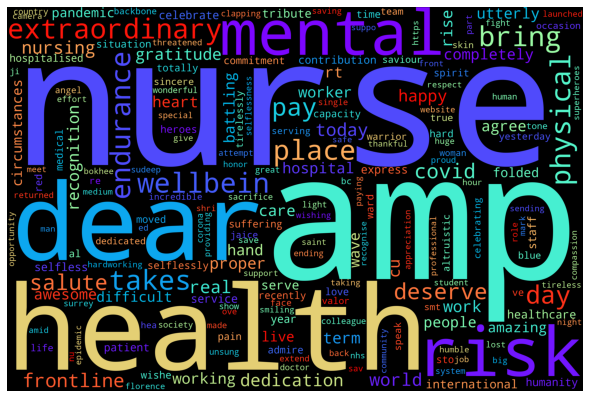

In [44]:
string=''
for i,r in tqdm(df.iterrows()):
    string+=' '.join(r['tokenized_text'])+' '

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='rainbow', collocations=False).generate(string)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# wordcloud.to_file('./wordcloud_india_unlemmatized.png')

In [45]:
lemmatizer = WordNetLemmatizer()
lemmatized_text = []
for i, r in df.iterrows():
    lemmatized_text.append([lemmatizer.lemmatize(k) for k in r['tokenized_text']])
df['lemmatized_text'] = lemmatized_text

10000it [00:01, 6507.47it/s]


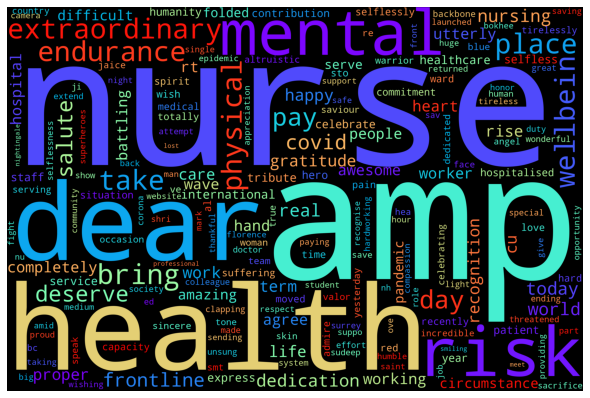

In [46]:
string=''
for i,r in tqdm(df.iterrows()):
    string+=' '.join(r['lemmatized_text'])+' '

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='rainbow', collocations=False).generate(string)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# wordcloud.to_file('./wordcloud_india_lemmatized.png')

In [47]:
# ! pip install alphabet_detector
from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()

script_counts = {}
for i,r in df.iterrows():
    temp = ad.detect_alphabet(r['text'])
    for j in temp:
        if script_counts.get(j):
            script_counts[j]+=1
        else:
            script_counts[j]=1


In [48]:
script_counts

{'LATIN': 10000, 'MATHEMATICAL': 10, 'DEVANAGARI': 8, 'INFORMATION': 2}

## Histograms

In [34]:
sentence_length = {}
for i,r in df.iterrows():
    s = sum(1 for i in r['text'].split(" "))
    if sentence_length.get(s):
        sentence_length[s]+=1
    else:
        sentence_length[s]=1


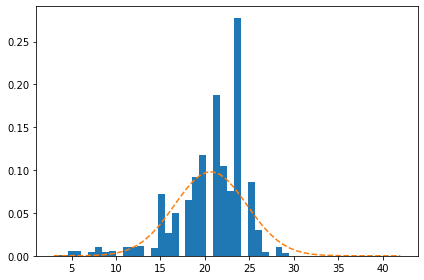

In [45]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

mu = sum(i*sentence_length[i] for i in sentence_length.keys())/sum(sentence_length[i] for i in sentence_length.keys())
sigma = (sum(((i-mu)**2)*sentence_length[i] for i in sentence_length.keys())/sum(sentence_length[i] for i in sentence_length.keys()))**0.5
x=[]
for i,r in sentence_length.items():
    for k in range(r):
        x.append(i)
num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=True)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
# ax.set_xlabel('Smarts')
# ax.set_ylabel('Probability density')
# ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [46]:
print(sigma)
print(mu)

4.065236001759307
20.6675


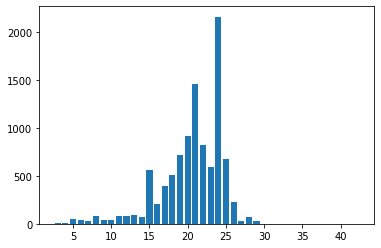

<Figure size 1080x720 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize =(7, 6)) 

# plt.hist([  [i]*sentence_length[i] for i in sentence_length.keys()  ])
plt.bar(list(sentence_length.keys()), [sentence_length[i] for i in sentence_length.keys()])
plt.figure(figsize = (15, 10))
plt.show()
# plt.savefig("bar_india_Eid.png")

## Co-occurrences of hashhtags

In [51]:
hashtag_co_occur_counts = {}
for i,r in df.iterrows():
    hs = r['hashtags'].split(", ")
    if len(hs)>1:
        hs.sort()
        for l in range(len(hs)-1):
            for k in range(l+1, len(hs)):
                hashtag_pair = f"[{hs[l]}, {hs[k]}]"
                if hashtag_co_occur_counts.get(hashtag_pair):
                    hashtag_co_occur_counts[hashtag_pair]+=1
                else:
                    hashtag_co_occur_counts[hashtag_pair]=1


In [52]:
hastag_co_occur_list = [ [i,r]  for i,r in hashtag_co_occur_counts.items()]

In [53]:
hastag_co_occur_list.sort(key = lambda x : x[1], reverse = True)

In [54]:
len(hastag_co_occur_list)

850

In [55]:
# ! pip install networkx
import networkx as nx
G = nx.Graph()

In [56]:
for i in hastag_co_occur_list:
    tags = i[0].strip('[]').split(', ')
    dis = (700-i[1])*100
    G.add_edge(tags[0], tags[1], weight=dis)

C:\Python38\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python38\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python38\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python38\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python38\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python38\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Python38\lib\site-packages\matplotlib\textpath.py

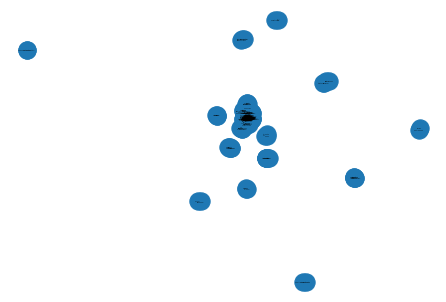

In [57]:
nx.draw(G, with_labels = True, font_size=1)

In [26]:
# nx.write_gexf(G, "india_eid.gexf")

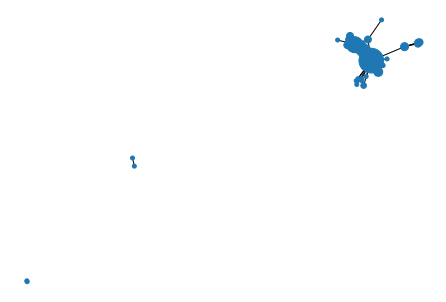

<Figure size 1440x2160 with 0 Axes>

In [27]:
# nx.draw_spring(G, with_labels = True)
# nx.draw_pygraphviz(G, with_labels = True)
nx.draw(G,
         node_size = [16 * G.degree(n) for n in G],
        #  node_color = [G.depth[n] for n in G],
         with_labels = False)

plt.figure(figsize = (20,30))
plt.show()

# User_mentions network

In [47]:
import networkx as nx
G = nx.Graph()

In [48]:
for i,r in df.iterrows():
    user = str(r['user_id'])
    users_mentioned = r['user_mentions'].split(', ')
    for k in users_mentioned:
        G.add_edge(user, k)

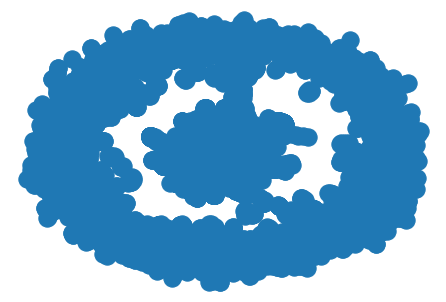

In [49]:
nx.draw(G,node_size = [16 * G.degree(n) for n in G],
        #  node_color = [G.depth[n] for n in G],
         with_labels = False)
